In [509]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from numpy import linalg
from scipy.linalg import expm
from scipy.optimize import fsolve
from scipy.special import comb
from tqdm import tqdm
import itertools

#sympy imports
import sympy as sp
from sympy import Matrix, symbols, sqrt
from sympy.physics.control.lti import TransferFunction
from sympy.parsing.mathematica import parse_mathematica
from sympy import var

#define constants
e = 1.602*10**(-19)#C
hbar = 1.054*10**(-34)#Js
h = hbar*2*np.pi
phi0 = hbar/2/e
np.set_printoptions(precision=7,suppress=True)


In [538]:
#initialize sympy variables
Lj, wj, zr, wr, Cj, Cjr, Cr, Lr, Crs, Cc, Cg, R, phi,s = symbols('Lj wj zr wr Cj Cjr Cr Lr Crs Cc Cg R phi s')
# Define a function that sets small coefficients to zero
precision = 1e-13
def set_small_coeffs_to_zero(expr):
    return expr.xreplace({n: 0 for n in expr.atoms(sp.Number) if abs(n) < precision})

# Assign parameter values.
zr_value = 50 #Ohm
wr_value = 2*np.pi*7 #GHz
Cr_value = 1/(wr_value*zr_value) #nf
Lr_value = zr_value/(wr_value) #nH
Cj_value = 10*10**(-6) #nF
Crs_value = 5.6*10**(-6) #nF
Cjr_value = 10*10**(-6) #nF
Cg_value = .00001*10**(-6) #nF
R_value =100 #Ohm
phi_value = np.pi/3


with open("Mathematica-files/Zresonators.txt",'r') as file:
    Zr_string = file.read()
with open("Mathematica-files/Zresonators.txt",'r') as file:
    Zacr_string = file.read()

Zr = parse_mathematica(Zr_string)
Zacr = parse_mathematica(Zacr_string)
Zr = Matrix(Zr)
Zacr = Matrix(Zacr)
# Zr = Zr.subs({Crs:Crs_value,Cg:Cg_value,R:R_value,phi:phi_value,Cr:Cr_value})

def wr_phi():
    # return sp.tan(phi/2)/R/(Crs+Cg)/3
    wr_an = sp.tan(phi/2)/R/((Cr+Crs)*Cg+Cr*Crs)*(Cr+Crs)/3 
    return wr_an

# choosing phi_value
target_w = 2*np.pi*36.25
def wry(phi_value):
    return np.tan(phi_value/2)/R_value/(Crs_value+Cg_value)
def f_wry(phi_value):
    return np.tan(phi_value/2)/R_value/(Crs_value+Cg_value)-target_w
phi_value = fsolve(f_wry,np.pi/3)[0]
phi_value = phi_value - 0.00*phi_value
print('phi/pi',phi_value/(np.pi))
print('wry/2pi',wry(phi_value)/2/np.pi)

ZacrN = Zacr.subs({Crs:Crs_value,Cg:Cg_value,R:R_value,phi:phi_value,Cr:Cr_value,s:1j*wr_value})
print('ZacrN',np.complex128(ZacrN[0,0])/Lr_value)

# choosing wr_value
wr_value = np.float64(wr_phi().subs({phi:phi_value,Crs:Crs_value,Cg:Cg_value,R:R_value,Cr:Cr_value}))
Cr_value = 1/(wr_value*zr_value) #nf
Lr_value = zr_value/(wr_value) #nH
print('wr/2pi',wr_value/2/np.pi)
print('Cr',Cr_value*1e6)
print('wyphi',np.tan(phi_value/2)/R_value/(Crs_value+Cg_value)/2/np.pi)

#saving the values
values = [zr_value, wr_value, Cr_value, Lr_value, Cj_value, Crs_value, Cjr_value, Cg_value, R_value, phi_value]
print(values)
print(wr_value/2/np.pi)
# Convert the list to a numpy array
values_array = np.array(values,dtype=np.float64)

# Save the array to a text file
np.savetxt("Mathematica-files/values.txt", values_array)
#now run the Mathematica file, then run all. 

wr-analytical (Cr + Crs)*tan(phi/2)/(3*R*(Cg*(Cr + Crs) + Cr*Crs))
phi/pi 0.08076405315764419
wry/2pi 36.24999999999999
ZacrN -43.61212419163962j
wr/2pi 12.23213983636004
Cr 260.22420479335466
wyphi 36.24999999999999
[50, 76.85680129518352, 0.00026022420479335467, 0.6505605119833866, 9.999999999999999e-06, 5.6e-06, 9.999999999999999e-06, 1.0000000000000001e-11, 100, 0.2537277560741905]
12.23213983636004


In [511]:
with open("Mathematica-files/wjchiral.txt",'r') as file:# Mathematica gives us the frequency of wj that gives chiral dynamics
    wjstring = file.read()

# wj_value = np.float64(parse_mathematica(wjstring))
# print(wr_value/2/np.pi)
# print(wj_value/2/np.pi)

## Loading the series matrix decomposition of Z

In [512]:
#now we read the output matrices from Mathematica
strings = ["A0","A1","A2","A3","A4","B1","B2","B3","B4","poles"]

list_strings = []
for string in strings:
    with open("Mathematica-files/"+string+".txt",'r') as file:
        list_strings.append(file.read())

dict_strings = dict(zip(strings,list_strings))

A0 = parse_mathematica(dict_strings["A0"])
A1 = parse_mathematica(dict_strings["A1"])
A2 = parse_mathematica(dict_strings["A2"])
A3 = parse_mathematica(dict_strings["A3"])
A4 = parse_mathematica(dict_strings["A4"])
B1 = parse_mathematica(dict_strings["B1"])
B2 = parse_mathematica(dict_strings["B2"])
B3 = parse_mathematica(dict_strings["B3"])
B4 = parse_mathematica(dict_strings["B4"])
poles = parse_mathematica(dict_strings["poles"])
print(poles)

A0 = Matrix(A0)
A1 = Matrix(A1)
A2 = Matrix(A2)
A3 = Matrix(A3)
A4 = Matrix(A4)
B1 = Matrix(B1)
B2 = Matrix(B2)
B3 = Matrix(B3)
B4 = Matrix(B4)
poles = Matrix(poles)
w1, w2, w3, w4 = -1j*poles[1], -1j*poles[2], -1j*poles[3], -1j*poles[4]
omegas = [w1,w2,w3,w4]

(0.0, 74.95850686904996*I, 75.53243714131904*I, 76.12890172118625*I, 233.14847717802442*I)


In [513]:
#we use those to define the impedance matrix in its Cauer form
Z = A0/s + (A1*s+B1)/(s**2+w1**2)+(A2*s+B2)/(s**2+w2**2)+(A3*s+B3)/(s**2+w3**2)+(A4*s+B4)/(s**2+w4**2)
print(Z.evalf(10))

ZacR = (A1*s)/(s**2+w1**2)+(A2*s)/(s**2+w2**2)+(A3*s)/(s**2+w3**2)+(A4*s)/(s**2+w4**2)
ZacNR = B1/(s**2+w1**2)+B2/(s**2+w2**2)+B3/(s**2+w3**2)+B4/(s**2+w4**2)
Zdc = A0/s

Matrix([[16.15119304*s/(s**2 + 54358.21241) + 314.1995666*s/(s**2 + 5795.609677) + 309.8976911*s/(s**2 + 5705.14906) + 302.350249*s/(s**2 + 5618.777752) + 50000.0/s, 314.1995666*s/(s**2 + 5795.609677) + (20271.34057 - 154.9488456*s)/(s**2 + 5705.14906) + (-151.1751245*s - 19627.36005)/(s**2 + 5618.777752) + (-8.075596519*s - 3261.12783)/(s**2 + 54358.21241), 314.1995666*s/(s**2 + 5795.609677) + (3261.12783 - 8.075596519*s)/(s**2 + 54358.21241) + (19627.36005 - 151.1751245*s)/(s**2 + 5618.777752) + (-154.9488456*s - 20271.34057)/(s**2 + 5705.14906)], [314.1995666*s/(s**2 + 5795.609677) + (3261.12783 - 8.075596519*s)/(s**2 + 54358.21241) + (19627.36005 - 151.1751245*s)/(s**2 + 5618.777752) + (-154.9488456*s - 20271.34057)/(s**2 + 5705.14906), 16.15119304*s/(s**2 + 54358.21241) + 314.1995666*s/(s**2 + 5795.609677) + 309.8976911*s/(s**2 + 5705.14906) + 302.350249*s/(s**2 + 5618.777752) + 50000.0/s, 314.1995666*s/(s**2 + 5795.609677) + (20271.34057 - 154.9488456*s)/(s**2 + 5705.14906) + (-1

# Constructing the Scattering and define wj

In [514]:
Smats = []
I3 = np.eye(3)

s_values = np.arange(wr_value-4,wr_value+1,1e-2/2)
for s_value in tqdm(s_values):
    Zs = np.array(Z.subs(s,1j*s_value),dtype=np.complex128)
    R0 = 500
    mat1 = np.linalg.inv(R0*I3+Zs)
    mat2 = Zs-R0*I3
    S = np.dot(mat1,mat2)
    Smats.append(S)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:11<00:00, 87.20it/s]


In [515]:
Smats = np.array(Smats)
print(Smats.shape)
print(Smats[0])

(1000, 3, 3)
[[0.021043 -0.9980909j 0.0325393-0.0237122j 0.0331207+0.0255689j]
 [0.0331207+0.0255689j 0.021043 -0.9980909j 0.0325393-0.0237122j]
 [0.0325393-0.0237122j 0.0331207+0.0255689j 0.021043 -0.9980909j]]


11.993407421722198
wr/2pi 12.23213983636004 R 100 Crs 5.6e-06 Cg 1.0000000000000001e-11 phi/pi 0.08076405315764419


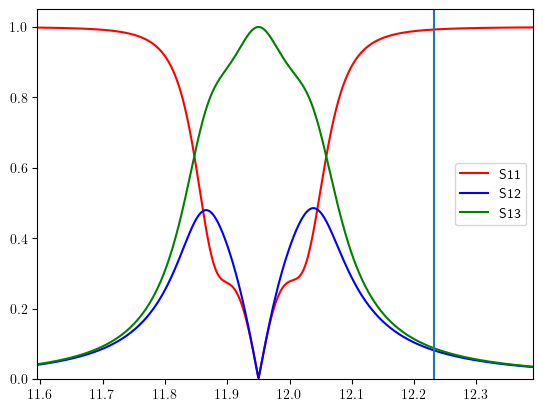

In [516]:
fig, ax = plt.subplots()

ax.plot(s_values/2/np.pi, np.abs(Smats[:,0,0]),label='S11',color='red')
ax.plot(s_values/2/np.pi, np.abs(Smats[:,0,1]),label='S12',color='blue')
ax.plot(s_values/2/np.pi, np.abs(Smats[:,0,2]),label='S13',color='green')

print(wr_value/2/np.pi-1.5/2/np.pi)
x0 = np.float64(wr_value/2/np.pi-4/2/np.pi)
x1 = np.float64(wr_value/2/np.pi+1/2/np.pi)
# x0 = np.float64((wj_value-1)/2/np.pi)
# x1 = np.float64((wr_value+1)/2/np.pi)
ax.plot([wr_value/2/np.pi,wr_value/2/np.pi],[0,1.5])
ax.legend()
ax.set_xlim(x0,x1)
ax.set_ylim(0,1.05)

print('wr/2pi',wr_value/2/np.pi,'R',R_value,'Crs',Crs_value,'Cg',Cg_value,'phi/pi',phi_value/np.pi)

In [517]:
min_value = np.min(np.abs(Smats[:,0,0]))
min_index = np.argmin(np.abs(Smats[:,0,0]))

print("Minimum value is:", min_value)
print("Index of minim3um value is:", s_values[min_index])

S11, S12, S13 = [],[],[]
for i in range(len(Smats)):
    Si = Smats[i]
    S11.append(Si[0,0])
    S12.append(Si[0,1])
    S13.append(Si[0,2])

S11 = np.array(S11)
S12 = np.array(S12)
S13 = np.array(S13)

Minimum value is: 0.002695571787912445
Index of minim3um value is: 75.08680129518149


In [518]:
# np.save("Plots/S/S11_almost_chiral",S11)
# np.save("Plots/S/S12_almost_chiral",S12)
# np.save("Plots/S/S13_almost_chiral",S13)
# np.save("Plots/S/s_values_almost_chiral",s_values)
# np.save("Plots/S/wr_almost_chiral",wr_value)

np.save("Plots/S/S11_chiral",S11)
np.save("Plots/S/S12_chiral",S12)
np.save("Plots/S/S13_chiral",S13)
np.save("Plots/S/s_values_chiral",s_values)
np.save("Plots/S/wr_chiral",wr_value)

# # # np.save("Plots/S/S11_example",S11)
# # # np.save("Plots/S/S12_example",S12)
# # # np.save("Plots/S/S13_example",S13)
# # # np.save("Plots/S/s_values_example",s_values)
# # # np.save("Plots/S/wj_wr_example",np.array([wj_value,wr_value]))

# Plotting for the paper

In [519]:
#colors
v_yellow = '#FDE725'
v_yellow2 = '#d0e11c'
v_pear = '#B5DE2B'
v_mint = '#35B779'
v_mblue = '#3E4989'
v_blue = '#482878'
v_russian = '#440154'
v_ll = '#31688E'

a_green = '#3CBD78' 
a_green2 = '#9FBB4A'
a_blue = '#3A68B7' 
a_brown = '#8D5A39'
a_brown2 = '#863033'
a_blue2 = '#44A9B1'

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

from matplotlib import rc
import matplotlib.pylab as plt

In [520]:
S11_chiral = np.load("Plots/S/S11_chiral.npy")
S12_chiral = np.load("Plots/S/S12_chiral.npy")
S13_chiral = np.load("Plots/S/S13_chiral.npy")
S11_almost_chiral = np.load("Plots/S/S11_almost_chiral.npy")
S12_almost_chiral = np.load("Plots/S/S12_almost_chiral.npy")
S13_almost_chiral = np.load("Plots/S/S13_almost_chiral.npy")
S11_example = np.load("Plots/S/S11_example.npy")
S12_example = np.load("Plots/S/S12_example.npy")
S13_example = np.load("Plots/S/S13_example.npy")
s_values_chiral = np.load("Plots/S/s_values_chiral.npy")
s_values_almost_chiral = np.load("Plots/S/s_values_almost_chiral.npy")
s_values_example = np.load("Plots/S/s_values_example.npy")
wj_wr_example = np.load("Plots/S/wj_wr_example.npy")
wj_example, wr_example =wj_wr_example[0], wj_wr_example[1]
wr_almost_chiral = np.load("Plots/S/wr_almost_chiral.npy")
wr_chiral = np.load("Plots/S/wr_chiral.npy")

0.9846529162018917
wr_chiral 0.9769701578757617


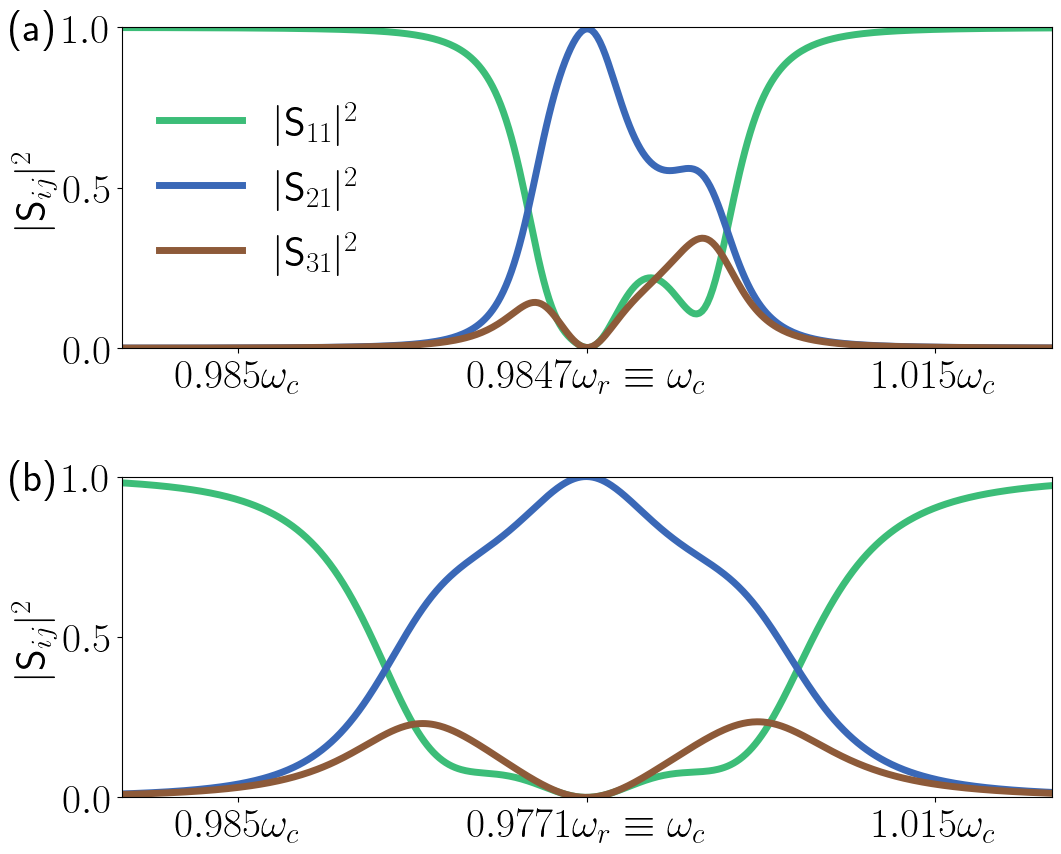

In [521]:
rc('text', usetex=True)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Computer Modern"
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=False)

fig= plt.figure(figsize=[12,10])
gs = fig.add_gridspec(2, 1, hspace=0.4, wspace=0.1)
ax2, ax3 = gs.subplots(sharex=False)

# ax1.plot(s_values_example/2/np.pi, np.abs(S11_example)**2,label='$|S_{11}|^2$',color=a_green,lw=5)
# ax1.plot(s_values_example/2/np.pi, np.abs(S13_example)**2,label='$|S_{12}|^2$',color=a_blue,lw=5)
# ax1.plot(s_values_example/2/np.pi, np.abs(S12_example)**2,label='$|S_{13}|^2$',color=a_brown,lw=5)
# ax1.set_ylim(0,1.0)

# ax1.set_xticks([wj_example/2/np.pi,wr_example/2/np.pi])
# ax1.set_yticks([0,0.5,1])
# ax1.set_xticklabels([r'$\overline{\omega}$',r'$\omega_{r}$'])
# ax1.tick_params(axis='both', which='major', labelsize=30)
# ax1.set_ylabel(r'$|S_{ij}|^2$',fontsize=30)
# ax1.legend(loc='center left',fontsize=25,frameon=False)
# ax1.text(-.12, .96, r'(a)', transform=ax1.transAxes, size=30, weight='normal')
# ax1.set_xlim(.99*wj_example/2/np.pi,1.01*wr_example/2/np.pi)

ax2.plot(s_values_almost_chiral/2/np.pi, np.abs(S11_almost_chiral)**2,label=r'$|\mathsf{S}_{11}|^2$',color=a_green,lw=5)
ax2.plot(s_values_almost_chiral/2/np.pi, np.abs(S13_almost_chiral)**2,label=r'$|\mathsf{S}_{21}|^2$',color=a_blue,lw=5)
ax2.plot(s_values_almost_chiral/2/np.pi, np.abs(S12_almost_chiral)**2,label=r'$|\mathsf{S}_{31}|^2$',color=a_brown,lw=5)
ax2.set_ylim(0,1.0)
ax2.legend(loc='center left',fontsize=30,frameon=False)


min_value = np.min(np.abs(S11_almost_chiral))
min_index = np.argmin(np.abs(S11_almost_chiral))
wchiral = s_values_almost_chiral[min_index]
print(wchiral/wr_almost_chiral)
ax2.set_xlim(.98*wchiral/2/np.pi,1.02*wchiral/2/np.pi)
ax2.set_xticks([.985*wchiral/2/np.pi,wchiral/2/np.pi,1.015*wchiral/2/np.pi])
ax2.set_yticks([0,0.5,1])
ax2.set_xticklabels([r'$0.985\omega_{c}$',r'$0.9847\omega_{r}\equiv \omega_c$',r'$1.015\omega_{c}$'])
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.set_ylabel(r'$|\mathsf{S}_{ij}|^2$',fontsize=30)
# ax2.legend(loc='center left',fontsize=20,frameon=False)
ax2.text(-.12, .96, r'(a)', transform=ax2.transAxes, size=30, weight='normal')


ax3.plot(s_values_chiral/2/np.pi, np.abs(S11_chiral)**2,label='$|S_{11}|^2$',color=a_green,lw=5)
ax3.plot(s_values_chiral/2/np.pi, np.abs(S13_chiral)**2,label='$|S_{12}|^2$',color=a_blue,lw=5)
ax3.plot(s_values_chiral/2/np.pi, np.abs(S12_chiral)**2,label='$|S_{13}|^2$',color=a_brown,lw=5)
ax3.set_ylim(0,1.0)

min_value = np.min(np.abs(S11_chiral))
min_index = np.argmin(np.abs(S11_chiral))
wchiral = s_values_chiral[min_index]
print('wr_chiral',wchiral/wr_chiral)
ax3.set_xlim(.98*wchiral/2/np.pi,1.02*wchiral/2/np.pi)
ax3.set_xticks([.985*wchiral/2/np.pi,wchiral/2/np.pi,1.015*wchiral/2/np.pi])
ax3.set_yticks([0,0.5,1])
ax3.set_xticklabels([r'$0.985\omega_{c}$',r'$0.9771\omega_{r}\equiv \omega_c$',r'$1.015\omega_{c}$'])
ax3.tick_params(axis='both', which='major', labelsize=30)
ax3.set_ylabel(r'$|\mathsf{S}_{ij}|^2$',fontsize=30)
# ax3.legend(loc='center left',fontsize=20,frameon=False)
ax3.text(-.12, .96, r'(b)', transform=ax3.transAxes, size=30, weight='normal')
# ax3.set_xlabel(r'$\omega/2\pi$ (MHz)',fontsize=25)
plt.savefig('Plots/S/scattering.pdf',bbox_inches='tight')
plt.show()



# Comparison with Jens S

In [522]:
# get the appropriate J
with open("Mathematica-files/Zresonators.txt",'r') as file:
    Zr_string = file.read()

Zr = parse_mathematica(Zr_string)
Zr = Matrix(Zr)
Zr = Zr.subs({Crs:Crs_value,Cg:Cg_value,R:R_value,phi:phi_value,Cr:Cr_value})

74.95850686904996*I


In [523]:
varphi = np.pi/6
I3 = np.eye(3)

min_value = np.min(np.abs(S11_chiral))
min_index = np.argmin(np.abs(S11_chiral))
wchiral = s_values_chiral[min_index]
wr = np.float64(-1j*(poles[1]+poles[2]+poles[3])/3)
wr = wchiral
J = np.complex128((1j/2)*Zr.subs(s,1j*wr_chiral)[0,1]/(zr_value/wr_chiral))
print('J',J, np.angle(J)/np.pi*6)
kappa = np.abs(np.complex128(J))

def omega_k(k,varphi):
    return wr+2*kappa*np.cos(2*np.pi*k/3+varphi)

def b_out(ws,j):# Eq. 21 of Ref. [19]. Assum b_in_1 = 1, b_in_j = 0 if j\neq 1.
    S = I3[0,j]
    for k in range(1,4):
        S+= (2*kappa/3)*np.exp(1j*2*np.pi*(-j*k/3))/(1j*(ws-omega_k(k,varphi))-kappa)
    return np.complex128(S)

w_range = np.linspace(wr-1.0,wr+1.0,200)
b_out_1 = []
b_out_2 = []
b_out_3 = []
for ws in tqdm(s_values_chiral[::3]):
    b_out_1.append(np.abs(b_out(ws,0))**2)
    b_out_2.append(np.abs(b_out(ws,1))**2)
    b_out_3.append(np.abs(b_out(ws,2))**2)

Lr 0.6658959915397092
J (0.30290290476304144-0.173305232461746j) -0.9925312335924726


100%|██████████| 334/334 [00:00<00:00, 27605.52it/s]


wrchirakl 75.08680129518149


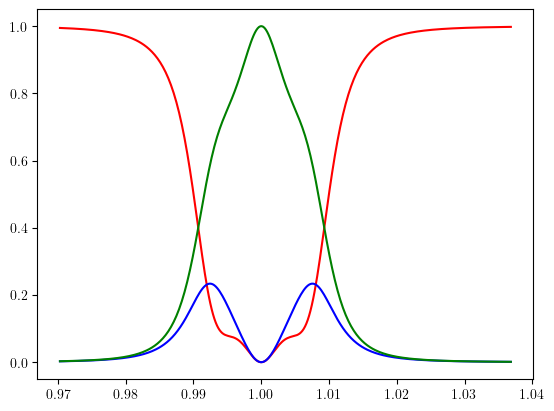

In [524]:
fig, ax = plt.subplots()

print('wrchirakl',wchiral)

ax.plot(s_values_chiral[::3]/wr, b_out_1,label='b_out_1',color='red')
ax.plot(s_values_chiral[::3]/wr, b_out_2,label='b_out_2',color='blue')
ax.plot(s_values_chiral[::3]/wr, b_out_3,label='b_out_3',color='green')

wr_chiral 0.9769701578757617


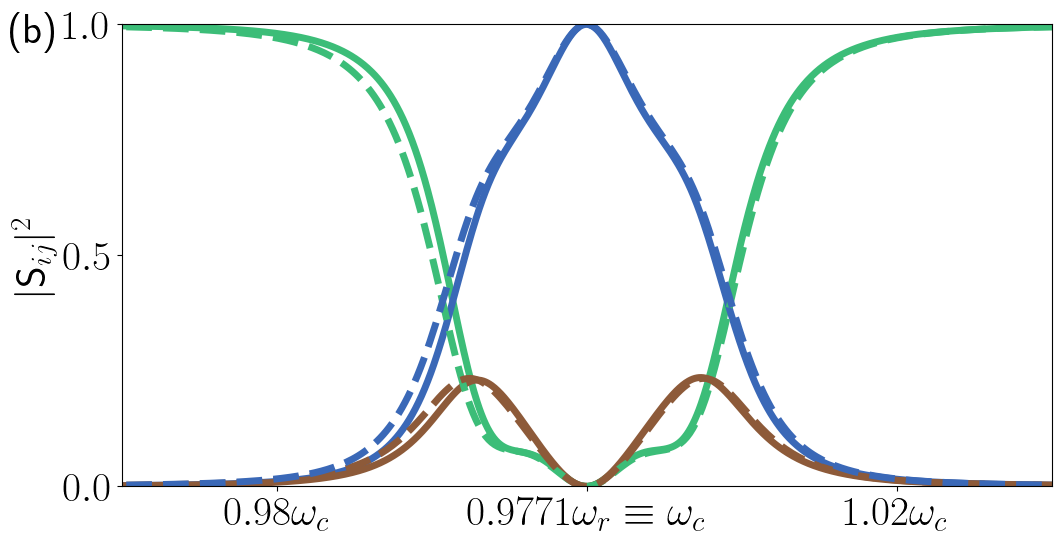

In [542]:
rc('text', usetex=True)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Computer Modern"
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=False)

fig= plt.figure(figsize=[12,6])
gs = fig.add_gridspec(1, 1, hspace=0.4, wspace=0.1)
ax3 = gs.subplots(sharex=False)

ax3.plot(s_values_chiral/2/np.pi, np.abs(S11_chiral)**2,label='$|S_{11}|^2$',color=a_green,lw=5)
ax3.plot(s_values_chiral/2/np.pi, np.abs(S13_chiral)**2,label='$|S_{12}|^2$',color=a_blue,lw=5)
ax3.plot(s_values_chiral/2/np.pi, np.abs(S12_chiral)**2,label='$|S_{13}|^2$',color=a_brown,lw=5)
ax3.plot(s_values_chiral[::3]/2/np.pi, b_out_1,label='b_out_1',color=a_green,ls='--',lw=5)
ax3.plot(s_values_chiral[::3]/2/np.pi, b_out_2,label='b_out_2',color=a_brown,ls='--',lw=5)
ax3.plot(s_values_chiral[::3]/2/np.pi, b_out_3,label='b_out_3',color=a_blue,ls='--',lw=5)
ax3.set_ylim(0,1.0)

min_value = np.min(np.abs(S11_chiral))
min_index = np.argmin(np.abs(S11_chiral))
wchiral = s_values_chiral[min_index]
print('wr_chiral',wchiral/wr_chiral)
ax3.set_xlim(.97*wchiral/2/np.pi,1.03*wchiral/2/np.pi)
ax3.set_xticks([.98*wchiral/2/np.pi,wchiral/2/np.pi,1.02*wchiral/2/np.pi])
ax3.set_yticks([0,0.5,1])
ax3.set_xticklabels([r'$0.98\omega_{c}$',r'$0.9771\omega_{r}\equiv \omega_c$',r'$1.02\omega_{c}$'])
ax3.tick_params(axis='both', which='major', labelsize=30)
ax3.set_ylabel(r'$|\mathsf{S}_{ij}|^2$',fontsize=30)
# ax3.legend(loc='center left',fontsize=20,frameon=False)
ax3.text(-.12, .96, r'(b)', transform=ax3.transAxes, size=30, weight='normal')
# ax3.set_xlabel(r'$\omega/2\pi$ (MHz)',fontsize=25)
plt.savefig('Plots/S/scattering.pdf',bbox_inches='tight')
plt.show()

